# Prédiction de la consommation d'électricité et des émissions CO2

## 1. Prédiction de la consommation d'énergie
    1.1 Avec ENERGYSTARScore
        1.1.1 Préparation des données
        1.1.2 Evaluation des modèles de base
        1.1.3 Optimisation des hyperparamètres
        1.1.4 Choix du modèle
    
    1.2 Sans ENERGYSTARScore
        1.2.1 Préparation des données
        1.2.2 Evaluation des modèles de base
        1.2.3 Optimisation des hyperparamètres
        1.2.4 Choix du modèle
    
## 2. Prédiction des émissions CO2
    2.1 Avec ENERGYSTARScore
        2.1.1 Préparation des données
        2.1.2 Evaluation des modèles de base
        2.1.3 Optimisation des hyperparamètres
        2.1.4 Choix du modèle
    
    2.2 Sans ENERGYSTARScore
        2.2.1 Préparation des données
        2.2.2 Evaluation des modèles de base
        2.2.3 Optimisation des hyperparamètres
        2.2.4 Choix du modèle
        
### 3. Conclusion


In [86]:
# Import des librairies utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Chargement du dataset
dataset = pd.read_csv('dataset.csv')

## 1. Prédiction de la consommation d'énergie


###   1.1 Avec ENERGYSTARScore

#### 1.1.1 Préparation des données

On sépare les variables catégorielles des variables numériques et on prend garde de ne pas inclure les variables cibles qui biaiseraient la performance de notre modèle

In [76]:
num_train = dataset[[ 'NumberofFloors', 'PropertyGFATotal','PropertyGFABuilding_s_', 'Parking_ratio',
                     'LargestPropertyUseTypeGFA','ENERGYSTARScore',
                     'PropertyGFAParking','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                     'GFA_per_floor','Old']]

In [77]:
cat_train = dataset[['BuildingType', 'Neighborhood', 'PrimaryPropertyType','SecondLargestPropertyUseType',
                     'ThirdLargestPropertyUseType']]


Concaténation des features catégorielles et numériques pour le train set

In [78]:
train = pd.concat([num_train, cat_train], axis=1)
train = train.reset_index(drop=True)
train

,NumberofFloors,PropertyGFATotal,PropertyGFABuilding_s_,Parking_ratio,LargestPropertyUseTypeGFA,ENERGYSTARScore,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,GFA_per_floor,Old,BuildingType,Neighborhood,PrimaryPropertyType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,12.0,88434,88434,0.000000,88434.0,65.0,0,0.0,0.0,6802.615385,88,Nonresidential,DOWNTOWN,Hotel,None,None
1,11.0,103566,88502,0.145453,757243.0,18.0,15064,100000.0,4622.0,7375.166667,19,Nonresidential,DOWNTOWN,Hotel,Restaurant,Restaurant
2,41.0,961990,961990,0.000000,123445.0,67.0,0,68009.0,0.0,22904.523810,46,Nonresidential,DOWNTOWN,Hotel,Parking,Swimming Pool
3,10.0,61320,61320,0.000000,81352.0,25.0,0,0.0,0.0,5574.545455,89,Nonresidential,DOWNTOWN,Hotel,None,None
4,18.0,119890,107430,0.103929,163984.0,46.0,12460,0.0,0.0,5654.210526,35,Nonresidential,DOWNTOWN,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,1.0,12294,12294,0.000000,21600.0,100.0,0,0.0,0.0,6147.000000,26,Nonresidential,GREATER DUWAMISH,Office,None,None
3423,1.0,16000,16000,0.000000,21600.0,100.0,0,0.0,0.0,8000.000000,12,Nonresidential,DOWNTOWN,Other,None,None
3424,1.0,13157,13157,0.000000,21600.0,100.0,0,0.0,0.0,6578.500000,42,Nonresidential,MAGNOLIA / QUEEN ANNE,Other,Fitness Center/Health Club/Gym,Swimming Pool
3425,1.0,14101,14101,0.000000,21600.0,100.0,0,0.0,484.0,7050.500000,27,Nonresidential,GREATER DUWAMISH,Mixed Use Property,Fitness Center/Health Club/Gym,Pre-school/Daycare


In [79]:
# Encodage des variables catégorielles à l'aide de get_dummies
train = pd.get_dummies(train) 

In [80]:
# Passage au log de la variable cible
y = np.log1p(dataset.SiteEnergyUse_kBtu__x)

In [81]:
# Split de notre train en 5 folds pour la validation croisée pour éviter l'overfitting
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state=42)

#### 1.1.2 Evaluation des modèles de base

Nous testerons plusieurs modèles, linéaires et non-linéaires, sans paramétrage ce qui nous donnera une idée du modèle le mieux adapté à notre problématique. Nous sélectionnerons ensuite le modèle le plus performant puis  affinerons ses hyperparamètres.

In [82]:
def pipe(model):
    pipe = Pipeline(steps=[('scaler', RobustScaler()),('model', model)])
    return pipe

In [10]:
# Création d'une liste contenant des modèles de base linéaires et non-linéaires
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
ridge = Ridge()
lasso = Lasso()
svc = SVC()
random_forrest = RandomForestRegressor()
decision_tree = DecisionTreeRegressor()
xg_boost = GradientBoostingRegressor()
ada_boost = AdaBoostRegressor()

In [11]:
models = [regression,ridge,lasso,random_forrest,decision_tree,xg_boost,ada_boost]

In [12]:
# Création d'une fonction retournant les scores de chaque modèle de base
dic={}
def metrics(model):
    pipe(model).fit(X_train, y_train)
    r2_score = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='r2')
    neg_median_absolute_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    neg_mean_absolute_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    neg_mean_absolute_percentage_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    neg_root_mean_squared_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    dic[str(model)] = (round(r2_score.mean(),2), neg_median_absolute_error.mean(), neg_mean_absolute_error.mean(),
                       neg_mean_absolute_percentage_error.mean(), neg_root_mean_squared_error.mean())
    return dic

In [13]:
for x in models:
    metrics(x)

In [14]:
# Tableau affichant les performances de chaque modèle selon différentes métriques
pd.DataFrame.from_dict(dic, orient="index", columns=['r2_score','neg_median_absolute_error','neg_mean_absolute_error',
                                                     'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'] )

,r2_score,neg_median_absolute_error,neg_mean_absolute_error,neg_mean_absolute_percentage_error,neg_root_mean_squared_error
LinearRegression(),-5.25,-1.700354,-1.700354,-0.142001,-5.837151
Ridge(),0.39,-1.272924,-1.272924,-0.104016,-1.869514
Lasso(),0.42,-1.836115,-1.836115,-0.155372,-1.936262
RandomForestRegressor(),0.97,-0.226109,-0.227733,-0.015620,-0.450937
DecisionTreeRegressor(),0.94,-0.320277,-0.321959,-0.022041,-0.634405
GradientBoostingRegressor(),0.97,-0.231929,-0.231684,-0.016198,-0.447506
AdaBoostRegressor(),0.90,-0.695330,-0.727552,-0.065663,-0.786338


Les modèles linéaires réalisent des performances insuffisantes (surtout la régression linéaire), on a à faire donc à un problème non-linéaire. A l'inverse les modèles non-linéaires ont des prédictions assez précises.

Notre choix du modèle se portera sur RandomForestRegressor qui a les meilleurs scores.

Afin d'optimiser le modèle, nous tenterons de trouver les meilleurs hyperparamètres à l'aide, dans un premier temps, de RandomSearchCV qui testera au hasard les hyperparamètres qu'on lui aura indiqué. 

Hyperparamètres de RandomForrestRegressor:
* n_estimator : nombre d'estimateurs, ce qui correspond au nombre d'arbres dans notre forêt aléatoire, le modèle gagnerait en efficacité en augmentant le nombre d'estimateurs
* max_features : le nombre ou le taux de features à prendre en compte dans notre modèle. On va tester différents taux (de 0.2 à 0.8)
* max_depth : profondeur de la forêt, la profondeur étant directement liée à la complexité du modèle
* min_samples_split : nombre d'individus minimum pour que le noeud soit séparé
* min_samples_leaf : nombre minimum d'individus pour la séparation de la feuille
* bootstrap : si le bootstrap se fait sur une partie du dataset ou sur son ensemble

Source : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

#### 1.1.3 Optimisation des hyperparamètres

In [15]:
# Instantiation d'un modèle random forrest de base
from sklearn.ensemble import RandomForestRegressor
random_forrest = RandomForestRegressor(random_state=42)

In [16]:
# Pipeline contenant le transformateur RobustScaler, pour standardiser nos variables numériques, et un modèle
# Random Forrest de base
pipe_rf = Pipeline(steps=[('robust scaler', RobustScaler()), ('random_forrest', random_forrest)])

In [17]:
# Grilles de recherche des meilleurs hyperparamètres pour notre modèle 
from random import randint
from sklearn.model_selection import RandomizedSearchCV
param_random = [{"random_forrest__n_estimators" : [int(x) for x in np.linspace(start=150, stop=2200, num=10)],
                 "random_forrest__max_features" : np.arange(.1,1,.1),
                 "random_forrest__max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
                 "random_forrest__min_samples_split" : np.arange(2,10,1),
                 "random_forrest__min_samples_leaf" : np.arange(2,10,1),
                 "random_forrest__bootstrap" : [True, False]}]

In [18]:
# Recherche des meilleurs hyperparamètres en validation croisée
random_search_rf=RandomizedSearchCV(pipe_rf, param_random, cv=5, scoring='r2', n_iter=200)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('robust scaler', RobustScaler()),
                                             ('random_forrest',
                                              RandomForestRegressor())]),
                   n_iter=100,
                   param_distributions=[{'random_forrest__bootstrap': [True,
                                                                       False],
                                         'random_forrest__max_depth': [5, 15,
                                                                       26, 36,
                                                                       47, 57,
                                                                       68, 78,
                                                                       89, 99,
                                                                       110],
                                         'random_forrest__max_features': array([0.2, 0.4, 0.6, 0.8]

In [19]:
# Modèle ayant les meilleurs hyperparamètres
random_search_rf.best_params_

{'random_forrest__n_estimators': 1516,
 'random_forrest__min_samples_split': 8,
 'random_forrest__min_samples_leaf': 2,
 'random_forrest__max_features': 0.6000000000000001,
 'random_forrest__max_depth': 78,
 'random_forrest__bootstrap': True}

In [20]:
# Score R2 en validation croisée du meilleur modèle sur le train set
random_search_rf.best_score_ 

0.970116646844002

#### 1.1.4 Choix du modèle

On choisit le meilleur modèle pour le tester sur le test set

In [84]:
# Score sur le test set du modèle le plus performant (ie avec les meilleurs hyperparamètres)
rf = RandomForestRegressor(n_estimators = 1516,min_samples_split= 8,
 min_samples_leaf= 2,
 max_features= 0.6000000000000001,
 max_depth=78,
 bootstrap= True)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=78, max_features=0.6000000000000001,
                      min_samples_leaf=2, min_samples_split=8,
                      n_estimators=1516)

In [87]:
r2_score(y_test,rf.predict(X_test))

0.9741260643171072

On voit que le score sur le test set est quasiment équivalent à celui sur le train set. Pas d'overfitting donc.

In [90]:
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

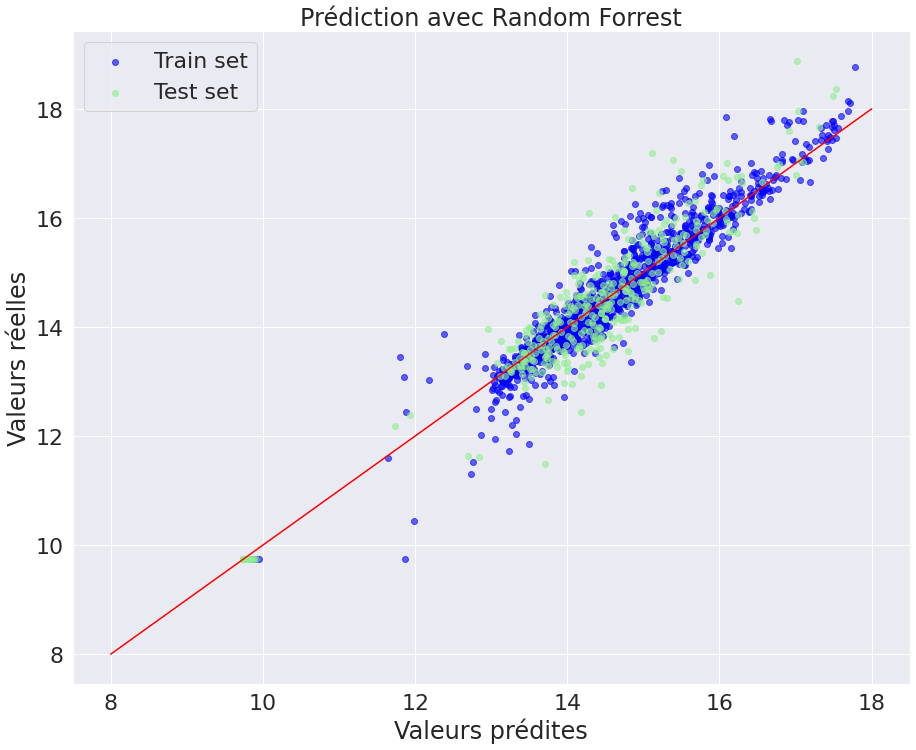

In [91]:
# Graphique représentant les prédictions/valeurs réelles vs valeurs prédites
sns.set(rc={'figure.figsize':(15,12)}, font_scale = 2)

plt.scatter(y_train_rf, y_train,  c = "blue", marker = "o", label = "Train set", alpha=0.6)
plt.scatter(y_test_rf, y_test, c = "lightgreen", marker = "o", label = "Test set", alpha=0.6)
plt.title("Prédiction avec Random Forrest")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.legend(loc = "upper left")
plt.plot([8,18], [8,18], c = "red")
plt.show()

## 1.2 Sans ENERGYSTARScore

#### 1.1.1 Préparation des données

On répète les mêmes opération qu'avant

In [23]:
num_train = dataset[[ 'NumberofFloors', 'PropertyGFATotal','PropertyGFABuilding_s_', 'Parking_ratio',
                     'LargestPropertyUseTypeGFA',
                     'PropertyGFAParking','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                     'GFA_per_floor','Old']]

In [24]:
cat_train = dataset[['BuildingType', 'Neighborhood', 'PrimaryPropertyType','SecondLargestPropertyUseType',
                     'ThirdLargestPropertyUseType']]

In [25]:
train = pd.concat([num_train, cat_train], axis=1)
train = train.reset_index(drop=True)
train

,NumberofFloors,PropertyGFATotal,PropertyGFABuilding_s_,Parking_ratio,LargestPropertyUseTypeGFA,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,GFA_per_floor,Old,BuildingType,Neighborhood,PrimaryPropertyType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,12.0,88434,88434,0.000000,88434.0,0,0.0,0.0,6802.615385,88,Nonresidential,DOWNTOWN,Hotel,None,None
1,11.0,103566,88502,0.145453,757243.0,15064,100000.0,4622.0,7375.166667,19,Nonresidential,DOWNTOWN,Hotel,Restaurant,Restaurant
2,41.0,961990,961990,0.000000,123445.0,0,68009.0,0.0,22904.523810,46,Nonresidential,DOWNTOWN,Hotel,Parking,Swimming Pool
3,10.0,61320,61320,0.000000,81352.0,0,0.0,0.0,5574.545455,89,Nonresidential,DOWNTOWN,Hotel,None,None
4,18.0,119890,107430,0.103929,163984.0,12460,0.0,0.0,5654.210526,35,Nonresidential,DOWNTOWN,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,1.0,12294,12294,0.000000,21600.0,0,0.0,0.0,6147.000000,26,Nonresidential,GREATER DUWAMISH,Office,None,None
3423,1.0,16000,16000,0.000000,21600.0,0,0.0,0.0,8000.000000,12,Nonresidential,DOWNTOWN,Other,None,None
3424,1.0,13157,13157,0.000000,21600.0,0,0.0,0.0,6578.500000,42,Nonresidential,MAGNOLIA / QUEEN ANNE,Other,Fitness Center/Health Club/Gym,Swimming Pool
3425,1.0,14101,14101,0.000000,21600.0,0,0.0,484.0,7050.500000,27,Nonresidential,GREATER DUWAMISH,Mixed Use Property,Fitness Center/Health Club/Gym,Pre-school/Daycare


In [26]:
train = pd.get_dummies(train) 

In [27]:
y = np.log1p(dataset.SiteEnergyUse_kBtu__x)

In [28]:
for x in models:
    metrics(x)

In [29]:
pd.DataFrame.from_dict(dic, orient="index", columns=['r2_score','neg_median_absolute_error','neg_mean_absolute_error',
                                                     'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'])

,r2_score,neg_median_absolute_error,neg_mean_absolute_error,neg_mean_absolute_percentage_error,neg_root_mean_squared_error
LinearRegression(),-5.25,-1.700354,-1.700354,-0.142001,-5.837151
Ridge(),0.39,-1.272924,-1.272924,-0.104016,-1.869514
Lasso(),0.42,-1.836115,-1.836115,-0.155372,-1.936262
RandomForestRegressor(),0.97,-0.226094,-0.226716,-0.015668,-0.450699
DecisionTreeRegressor(),0.94,-0.320806,-0.322565,-0.022224,-0.625421
GradientBoostingRegressor(),0.97,-0.231920,-0.231571,-0.016201,-0.447906
AdaBoostRegressor(),0.90,-0.709910,-0.730256,-0.066834,-0.815233


In [30]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV
param_random = [{"random_forrest__n_estimators" : [int(x) for x in np.linspace(start=150, stop=2200, num=10)],
                 "random_forrest__max_features" : np.arange(.1,1,.1),
                 "random_forrest__max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
                 "random_forrest__min_samples_split" : np.arange(2,10,1),
                 "random_forrest__min_samples_leaf" : np.arange(2,10,1),
                 "random_forrest__bootstrap" : [True, False]}]

In [32]:
random_search_rf=RandomizedSearchCV(pipe_rf, param_random, cv=5, scoring='r2', n_iter=200)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('robust scaler', RobustScaler()),
                                             ('random_forrest',
                                              RandomForestRegressor())]),
                   param_distributions=[{'random_forrest__bootstrap': [True,
                                                                       False],
                                         'random_forrest__max_depth': [5, 15,
                                                                       26, 36,
                                                                       47, 57,
                                                                       68, 78,
                                                                       89, 99,
                                                                       110],
                                         'random_forrest__max_features': array([0.2, 0.4, 0.6, 0.8]),
                            

In [33]:
random_search_rf.best_params_

{'random_forrest__n_estimators': 1516,
 'random_forrest__min_samples_split': 8,
 'random_forrest__min_samples_leaf': 3,
 'random_forrest__max_features': 0.8,
 'random_forrest__max_depth': 47,
 'random_forrest__bootstrap': True}

In [34]:
random_search_rf.best_score_

0.9689801531298257

#### 1.1.4 Choix du modèle

In [93]:
# Score sur le test set du modèle le plus performant (ie avec les meilleurs hyperparamètres)
rf = RandomForestRegressor(n_estimators = 1516,min_samples_split= 8,
 min_samples_leaf= 3,
 max_features= 0.8000000000000001,
 max_depth=47,
 bootstrap= True)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=47, max_features=0.8000000000000002,
                      min_samples_leaf=3, min_samples_split=8,
                      n_estimators=1516)

In [94]:
r2_score(y_test,rf.predict(X_test))

0.9748001278086823

Le modèle est légèrement plus performant sur le test. On constate aussi l'importance toute relative de la variable ENERGYSTARScore dans la prédiction.

In [35]:
y_train_rf = random_search_rf.predict(X_train)
y_test_rf = random_search_rf.predict(X_test)

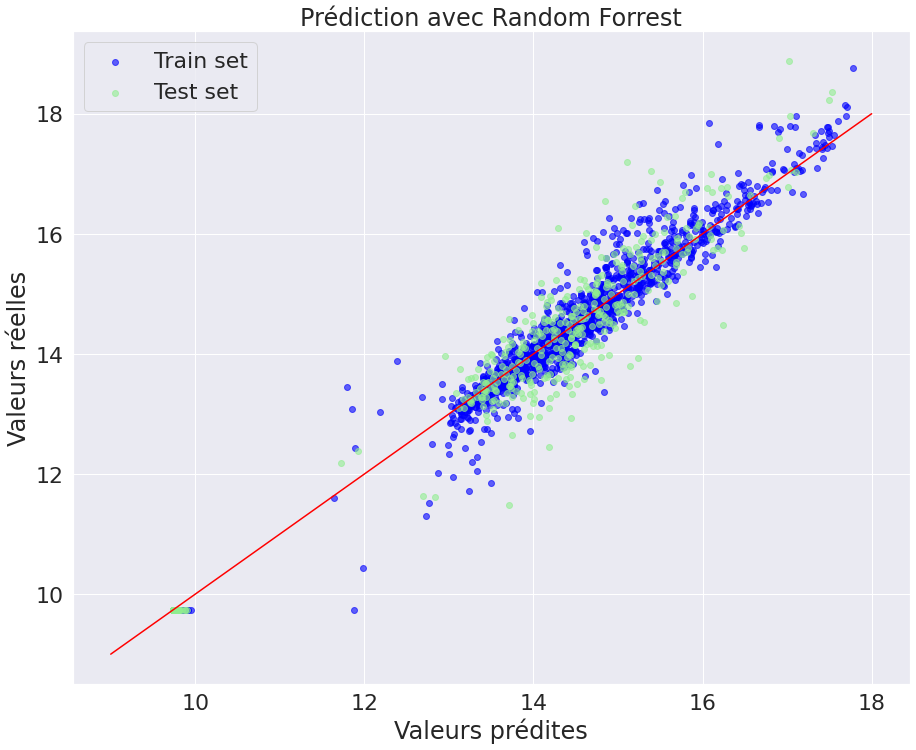

In [96]:
# Graphique représentant les prédictions/valeurs réelles vs valeurs prédites

sns.set(rc={'figure.figsize':(15,12)}, font_scale = 2)

plt.scatter(y_train_rf, y_train,  c = "blue", marker = "o", label = "Train set", alpha=0.6)
plt.scatter(y_test_rf, y_test, c = "lightgreen", marker = "o", label = "Test set", alpha=0.6)
plt.title("Prédiction avec Random Forrest")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.legend(loc = "upper left")
plt.plot([9,18], [9,18], c = "red")
plt.show()

## 2. Prédiction des émissions CO2


### 2.1 Avec ENERGYSTARScore


#### 2.1.1 Préparation des données

In [112]:
num_train = dataset[[ 'NumberofFloors', 'PropertyGFATotal','PropertyGFABuilding_s_', 'Parking_ratio',
                     'LargestPropertyUseTypeGFA','ENERGYSTARScore',
                     'PropertyGFAParking','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                     'GFA_per_floor','Old']]

In [113]:
cat_train = dataset[['BuildingType', 'Neighborhood', 'PrimaryPropertyType','SecondLargestPropertyUseType',
                     'ThirdLargestPropertyUseType']]

In [114]:
train = pd.get_dummies(train) 

In [115]:
y = np.log1p(dataset.TotalGHGEmissions_x)

In [116]:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state=42)

In [42]:
def pipe(model):
    pipe = Pipeline(steps=[('scaler', RobustScaler()),('model', model)])
    return pipe

In [43]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
ridge = Ridge()
lasso = Lasso()
svc = SVC()
random_forrest = RandomForestRegressor()
decision_tree = DecisionTreeRegressor()
xg_boost = GradientBoostingRegressor()
ada_boost = AdaBoostRegressor()

In [44]:
models = [regression,ridge,lasso,random_forrest,decision_tree,xg_boost,ada_boost]

In [45]:
dic={}
def metrics(model):
    pipe(model).fit(X_train, y_train)
    r2_score = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='r2')
    neg_median_absolute_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    neg_mean_absolute_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    neg_mean_absolute_percentage_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    neg_root_mean_squared_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    dic[str(model)] = (round(r2_score.mean(),2), neg_median_absolute_error.mean(), neg_mean_absolute_error.mean(),
                       neg_mean_absolute_percentage_error.mean(), neg_root_mean_squared_error.mean())
    return dic

In [46]:
for x in models:
    metrics(x)

In [47]:
# Tableau affichant les performances de chaque modèle selon différentes métriques
pd.DataFrame.from_dict(dic, orient="index", columns=['r2_score','neg_median_absolute_error','neg_mean_absolute_error',
                                                     'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'] )

,r2_score,neg_median_absolute_error,neg_mean_absolute_error,neg_mean_absolute_percentage_error,neg_root_mean_squared_error
LinearRegression(),-1996039.77,-71.402328,-71.402328,-39.901035,-969.941696
Ridge(),-0.00,-0.917433,-0.917433,-0.399683,-1.353280
Lasso(),0.25,-1.014302,-1.014302,-0.442460,-1.219367
RandomForestRegressor(),0.69,-0.461231,-0.461366,-0.176643,-0.787198
DecisionTreeRegressor(),0.42,-0.603048,-0.604067,-0.222413,-1.083449
GradientBoostingRegressor(),0.69,-0.479302,-0.479719,-0.187177,-0.782839
AdaBoostRegressor(),0.60,-0.812136,-0.711316,-0.410362,-0.935642


In [105]:
from sklearn.ensemble import RandomForestRegressor
random_forrest = RandomForestRegressor(random_state=42)

In [117]:
pipe_rf = Pipeline(steps=[('robust scaler', RobustScaler()), ('random_forrest', random_forrest)])

In [50]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV
param_random = [{"random_forrest__n_estimators" : [int(x) for x in np.linspace(start=150, stop=2200, num=10)],
                 "random_forrest__max_features" : np.arange(.1,1,.1),
                 "random_forrest__max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
                 "random_forrest__min_samples_split" : np.arange(2,10,1),
                 "random_forrest__min_samples_leaf" : np.arange(2,10,1),
                 "random_forrest__bootstrap" : [True, False]}]

In [51]:
random_search_rf=RandomizedSearchCV(pipe_rf, param_random, cv=5, scoring='r2', n_iter=100)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('robust scaler', RobustScaler()),
                                             ('random_forrest',
                                              RandomForestRegressor())]),
                   param_distributions=[{'random_forrest__bootstrap': [True,
                                                                       False],
                                         'random_forrest__max_depth': [5, 15,
                                                                       26, 36,
                                                                       47, 57,
                                                                       68, 78,
                                                                       89, 99,
                                                                       110],
                                         'random_forrest__max_features': array([0.2, 0.4, 0.6, 0.8]),
                            

In [52]:
random_search_rf.best_params_

{'random_forrest__n_estimators': 833,
 'random_forrest__min_samples_split': 4,
 'random_forrest__min_samples_leaf': 9,
 'random_forrest__max_features': 0.8,
 'random_forrest__max_depth': 26,
 'random_forrest__bootstrap': True}

In [53]:
random_search_rf.best_score_ 

0.7006200490042133

#### 1.1.4 Choix du modèle

In [107]:
rf = RandomForestRegressor(n_estimators=833,
 min_samples_split=4,
 min_samples_leaf=9,
 max_features=0.8,
 max_depth=26,
 bootstrap=True)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=26, max_features=0.8, min_samples_leaf=9,
                      min_samples_split=4, n_estimators=833)

In [108]:
r2_score(y_test,rf.predict(X_test))

0.7431860214940194

On voit une amélioration assez appréciable en terme de performance sur le test set de notre modèle.

In [110]:
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

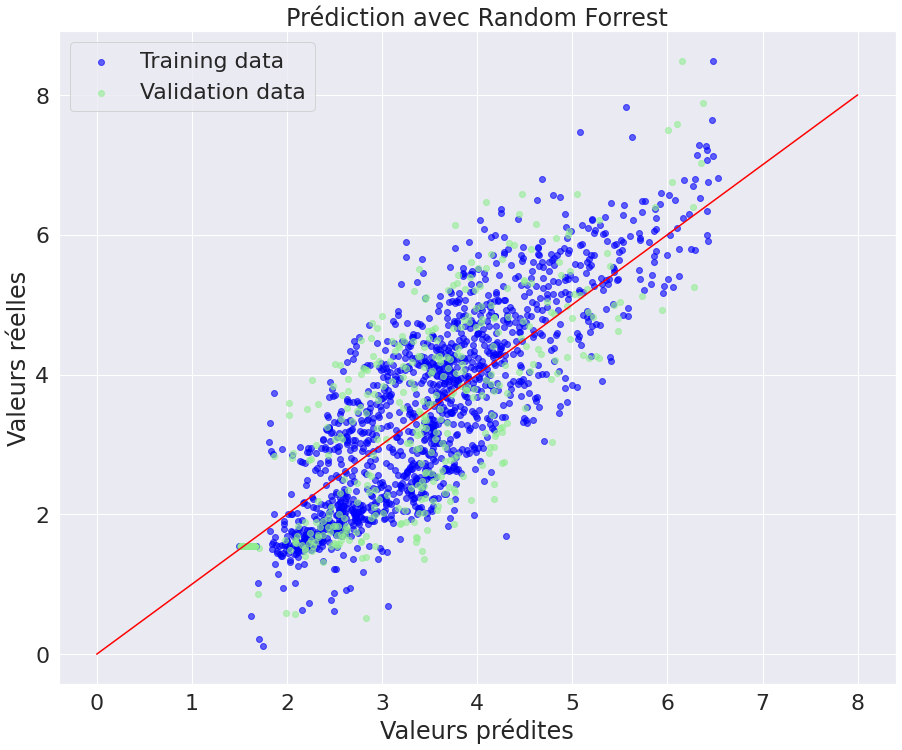

In [111]:
sns.set(rc={'figure.figsize':(15,12)}, font_scale = 2)

plt.scatter(y_train_rf, y_train,  c = "blue", marker = "o", label = "Training data", alpha=0.6)
plt.scatter(y_test_rf, y_test, c = "lightgreen", marker = "o", label = "Validation data", alpha=0.6)
plt.title("Prédiction avec Random Forrest")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.legend(loc = "upper left")
plt.plot([0,8], [0,8], c = "red")
plt.show()

### 2.2 Sans ENERGYSTARScore


#### 2.1.1 Préparation des données

In [122]:
num_train = dataset[[ 'NumberofFloors', 'PropertyGFATotal','PropertyGFABuilding_s_', 'Parking_ratio',
                     'LargestPropertyUseTypeGFA',
                     'PropertyGFAParking','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                     'GFA_per_floor','Old']]

In [123]:
cat_train = dataset[['BuildingType', 'Neighborhood', 'PrimaryPropertyType','SecondLargestPropertyUseType',
                     'ThirdLargestPropertyUseType']]

In [124]:
train = pd.get_dummies(train) 

In [125]:
y = np.log1p(dataset.TotalGHGEmissions_x)

In [126]:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state=42)

In [127]:
def pipe(model):
    pipe = Pipeline(steps=[('scaler', RobustScaler()),('model', model)])
    return pipe

In [128]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
ridge = Ridge()
lasso = Lasso()
svc = SVC()
random_forrest = RandomForestRegressor()
decision_tree = DecisionTreeRegressor()
xg_boost = GradientBoostingRegressor()
ada_boost = AdaBoostRegressor()

In [63]:
models = [regression,ridge,lasso,random_forrest,decision_tree,xg_boost,ada_boost]

In [64]:
dic={}
def metrics(model):
    pipe(model).fit(X_train, y_train)
    r2_score = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='r2')
    neg_median_absolute_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    neg_mean_absolute_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    neg_mean_absolute_percentage_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    neg_root_mean_squared_error = cross_val_score(pipe(model), X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    dic[str(model)] = (round(r2_score.mean(),2), neg_median_absolute_error.mean(), neg_mean_absolute_error.mean(),
                       neg_mean_absolute_percentage_error.mean(), neg_root_mean_squared_error.mean())
    return dic

In [65]:
for x in models:
    metrics(x)

In [66]:
pd.DataFrame.from_dict(dic, orient="index", columns=['r2_score','neg_median_absolute_error','neg_mean_absolute_error',
                                                     'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'] )

,r2_score,neg_median_absolute_error,neg_mean_absolute_error,neg_mean_absolute_percentage_error,neg_root_mean_squared_error
LinearRegression(),-1996039.77,-71.402328,-71.402328,-39.901035,-969.941696
Ridge(),-0.00,-0.917433,-0.917433,-0.399683,-1.353280
Lasso(),0.25,-1.014302,-1.014302,-0.442460,-1.219367
RandomForestRegressor(),0.69,-0.458869,-0.460023,-0.176171,-0.788099
DecisionTreeRegressor(),0.42,-0.603281,-0.599264,-0.222428,-1.080285
GradientBoostingRegressor(),0.69,-0.479332,-0.479881,-0.187624,-0.783016
AdaBoostRegressor(),0.48,-0.899301,-0.708696,-0.373692,-0.880117


In [67]:
from sklearn.ensemble import RandomForestRegressor
random_forrest = RandomForestRegressor(random_state=42)

In [68]:
pipe_rf = Pipeline(steps=[('robust scaler', RobustScaler()), ('random_forrest', RandomForestRegressor())])

In [69]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV
param_random = [{"random_forrest__n_estimators" : [int(x) for x in np.linspace(start=150, stop=2200, num=10)],
                 "random_forrest__max_features" : np.arange(.1,.1,.1),
                 "random_forrest__max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
                 "random_forrest__min_samples_split" : np.arange(2,10,1),
                 "random_forrest__min_samples_leaf" : np.arange(2,10,1),
                 "random_forrest__bootstrap" : [True, False]}]

In [70]:
random_search_rf=RandomizedSearchCV(pipe_rf, param_random, cv=5, scoring='r2', n_iter=200)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('robust scaler', RobustScaler()),
                                             ('random_forrest',
                                              RandomForestRegressor())]),
                   param_distributions=[{'random_forrest__bootstrap': [True,
                                                                       False],
                                         'random_forrest__max_depth': [5, 15,
                                                                       26, 36,
                                                                       47, 57,
                                                                       68, 78,
                                                                       89, 99,
                                                                       110],
                                         'random_forrest__max_features': array([0.2, 0.4, 0.6, 0.8]),
                            

In [71]:
random_search_rf.best_params_

{'random_forrest__n_estimators': 1288,
 'random_forrest__min_samples_split': 6,
 'random_forrest__min_samples_leaf': 5,
 'random_forrest__max_features': 0.8,
 'random_forrest__max_depth': 5,
 'random_forrest__bootstrap': True}

In [72]:
random_search_rf.best_score_ 

0.7029597289121873

In [129]:
rf = RandomForestRegressor(n_estimators=1288,
 min_samples_split=6,
 min_samples_leaf=5,
 max_features=0.8,
 max_depth=5,
 bootstrap=True)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=0.8, min_samples_leaf=5,
                      min_samples_split=6, n_estimators=1288)

In [130]:
r2_score(y_test,rf.predict(X_test))

0.7443171124162059

Le modèle a de meilleures performances sur le test set, comme c'est le cas avec la variable ENERGYSTARScore 

In [73]:
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

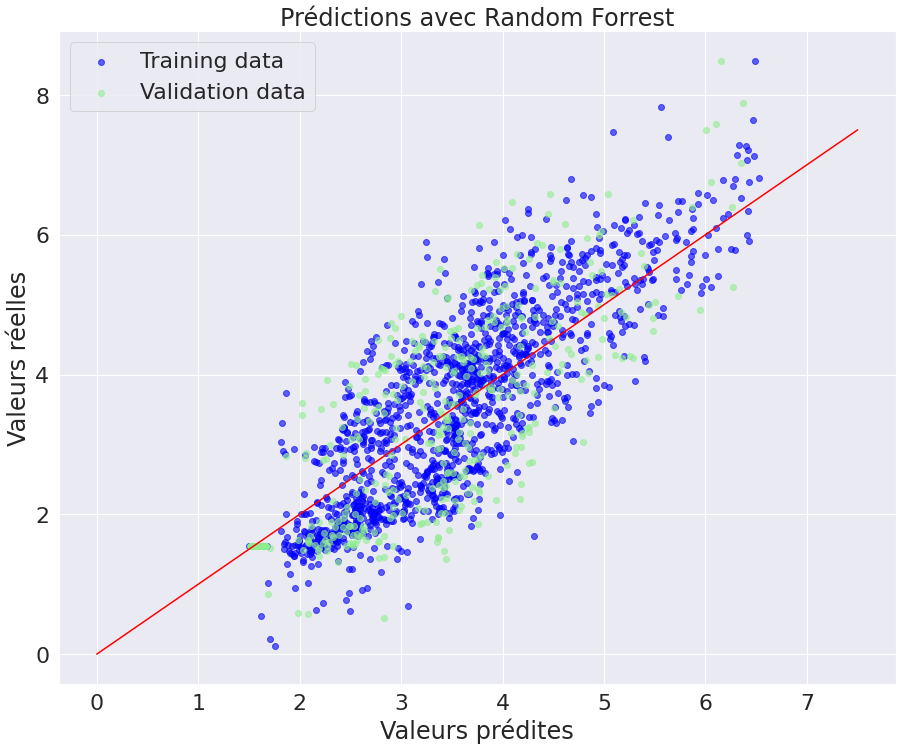

In [131]:
sns.set(rc={'figure.figsize':(15,12)}, font_scale = 2)

plt.scatter(y_train_rf, y_train,  c = "blue", marker = "o", label = "Training data", alpha=0.6)
plt.scatter(y_test_rf, y_test, c = "lightgreen", marker = "o", label = "Validation data", alpha=0.6)
plt.title("Prédictions avec Random Forrest")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.legend(loc = "upper left")
plt.plot([0,7.5], [0,7.5], c = "red")
plt.show()

## 3. Conclusion

D'après les données dont on dispose, on arrive à une prédiction très précise de la consommation d'électricité, notre modèle capture l'essentiel de la variance, en témoigne le coefficient de détermination linéaire proche de 1 atteint (0.97).

Concernant les émissions de CO2, notre modèle commet nettement plus d'erreurs mais demeure suffisamment fiable pour envisager son utilisation

Dans les deux cas l'importance de la variable ENERGYSTARScore est anecdotique vu le différentiel de performances avec et sans.